In [82]:
import codecs
import pickle
from pythainlp.tokenize import word_tokenize
from pythainlp.tag import pos_tag
from pythainlp.tokenize import Tokenizer
from pythainlp.util.trie import Trie, dict_trie
from pythainlp.corpus.common import thai_words
from nltk.tokenize import RegexpTokenizer
import glob
import nltk
import scipy.stats
import re
from sklearn_crfsuite import scorers,metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate,train_test_split
import sklearn_crfsuite
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
file_name="traindata1" # ชื่อไฟล์คลังข้อมูล
def get_data(fileopen):
	"""
    สำหรับใช้อ่านทั้งหมดทั้งในไฟล์ทีละรรทัดออกมาเป็น list
    """
	with codecs.open(fileopen, 'r',encoding='utf-8-sig') as f:
		lines = f.read().splitlines()
	return [a for a in lines if Unique(a)]# เอาไม่ซ้ำกัน

<h1># จัดการกับ tag ที่ไม่ได้ tag

In [3]:
def toolner_to_tag(text):
 text=text.strip()
 text=re.sub("<[^>]*>","",text)
 text=re.sub("(\[\/(.*?)\])","\\1***",text)#.replace('(\[(.*?)\])','***\\1')#  ตัดการกับพวกไม่มี tag word
 text=re.sub("(\[\w+\])","***\\1",text)
 text2=[]
 for i in text.split('***'):
  if "[" in i:
   text2.append(i)
  else:
   text2.append("[word]"+i+"[/word]")
 text="".join(text2)#re.sub("[word][/word]","","".join(text2))
 return text.replace("[word][/word]","")

In [4]:
toolner_to_tag("เราจะไปเดินเล่นที่[LOCATION]หนองคาย[/LOCATION] พร้อมกับนั่งเรือข้ามไป[LOCATION]ประเทศลาว[/LOCATION]")

'[word]เราจะไปเดินเล่นที่[/word][LOCATION]หนองคาย[/LOCATION][word] พร้อมกับนั่งเรือข้ามไป[/word][LOCATION]ประเทศลาว[/LOCATION]'

In [5]:
def text2conll2002(text,pos=True):
    """
    ใช้แปลงข้อความให้กลายเป็น conll2002
    """
    text=toolner_to_tag(text) # นำไปใส่ tag [word] "[word]เราจะไปเดินเล่นที่[/word]"
    text=text.replace("''",'"')
    text=text.replace("’",'"').replace("‘",'"')#.replace('"',"")
    tag=tokenizer.tokenize(text) # แยก tag ออกมาจากข้อความ [('word', 'ฉันจะไปเดินเล่นที่', 'word'),('LOCATION', 'หนองคาย', 'LOCATION'),('word', 'พร้อมกับนั่งเรือข้ามไป', 'word'),('LOCATION', 'ประเทศลาว', 'LOCATION')]
    j=0
    conll2002="" # ประกาศตัวแปรเก็บ conll2002
    for tagopen,text,tagclose in tag: # ลูปใน tag โดยเป็น (tagopen,text,tagclose) word_tokenize(text,engine="newmm")
        word_cut=_tokenizer.word_tokenize(text) # ใช้ตัวตัดคำ newmm ของ PyThaiNLP ['ฉัน', 'จะ', 'ไป', 'เดินเล่น', 'ที่']['หนองคาย']['พร้อมกับ', 'นั่ง', 'เรือ', 'ข้าม', 'ไป']['ประเทศ', 'ลาว']
        i=0
        txt5=""
        while i<len(word_cut): #ลูปตามจำนวน token ที่ตัดในtag
            if word_cut[i]=="''" or word_cut[i]=='"':pass
            elif i==0 and tagopen!='word': # ไม่เป็น tag [word] และเป็น i หรือตัวเริ่มต้น tag
                txt5+=word_cut[i]
                txt5+='\t'+''+tagopen
            elif tagopen!='word':
                txt5+=word_cut[i]
                txt5+='\t'+''+tagopen
            else: # เป็น [word]
                txt5+=word_cut[i]
                txt5+='\t'+'O'
            txt5+='\n'
            #j+=1
            i+=1
        conll2002+=txt5
    if pos==False:
        return conll2002
    return postag(conll2002)

In [6]:
def postag(text):
    listtxt=[i for i in text.split('\n') if i!='']
    list_word=[]
    for data in listtxt:
        list_word.append(data.split('\t')[0])
    #print(text)
    list_word=pos_tag(list_word,engine="perceptron")
    text=""
    i=0
    for data in listtxt:
        text+=data.split('\t')[0]+'\t'+list_word[i][1]+'\t'+data.split('\t')[1]+'\n'
        i+=1
    return text

In [7]:
def alldata(lists):
    text=""
    for data in lists:
        text+=text2conll2002(data)
        text+='\n'
    return text

In [8]:
def alldata_list(lists):
    data_all=[] 
    print(lists)
    for data in lists:
        data_num=[]
        try:
            txt=text2conll2002(data,pos=True).split('\n') # นำไปแปลงเป็น conll2002
            
            for d in txt:
                tt=d.split('\t')
                if d!="":
                    if len(tt)==3:
                        data_num.append((tt[0],tt[1],tt[2]))
                    else:
                        data_num.append((tt[0],tt[1]))
            #print(data_num)
            data_all.append(data_num)
        except:
            print(data)
    #print(data_all)
    return data_all

In [9]:
def alldata_list_str(lists):
	string=""
	for data in lists:
		string1=""
		for j in data:
			string1+=j[0]+"	"+j[1]+"	"+j[2]+"\n"
		string1+="\n"
		string+=string1
	return string

In [10]:
def get_data_tag(listd):
	list_all=[]
	c=[]
	for i in listd:
		if i !='':
			c.append((i.split("\t")[0],i.split("\t")[1],i.split("\t")[2]))
		else:
			list_all.append(c)
			c=[]
	return list_all

In [11]:
def getall(lista):
    ll=[]  
    print(lista)
    for i in lista:
        o=True
        for j in ll:
            if re.sub("\[(.*?)\]","",i)==re.sub("\[(.*?)\]","",j):
                o=False
                break
        if o==True:
            ll.append(i)
            print(i)
    return ll

In [79]:
def get_ner(text):
    #_tokenizer = Tokenizer(custom_dict=trie, engine='newmm')
    #_tokenizer.word_tokenize(text)
    word_cut=_tokenizer.word_tokenize(text)
    list_word=pos_tag(word_cut,engine='perceptron')
    X_test = extract_features([(data,list_word[i][1]) for i,data in enumerate(word_cut)])
    y_=crf.predict_single(X_test)
    d.append([(word_cut[i],data) for i,data in enumerate(y_)])
    #[(word_cut[i],list_word[i][1],data) for i,data in enumerate(y_)]
    #print(d)
    return True,y_


In [12]:
def doc2features(doc, i):
    word = doc[i][0]
    postag = doc[i][1]
    # Features from current word
    features={
        'word.word': word,
        'word.isspace':word.isspace(),
        'postag':postag,
        'word.isdigit()': word.isdigit()
    }
    if i > 0:
        prevword = doc[i-1][0]
        postag1 = doc[i-1][1]
        features['word.prevword'] = prevword
        features['word.previsspace']=prevword.isspace()
        features['word.prepostag'] = postag1
        features['word.prevwordisdigit'] = prevword.isdigit()
    else:
        features['BOS'] = True # Special "Beginning of Sequence" tag
    # Features from next word
    if i < len(doc)-1:
        nextword = doc[i+1][0]
        postag1 = doc[i+1][1]
        features['word.nextword'] = nextword
        features['word.nextisspace']=nextword.isspace()
        features['word.nextpostag'] = postag1
        features['word.nextwordisdigit'] = nextword.isdigit()
    else:
        features['EOS'] = True # Special "End of Sequence" tag
    return features

In [13]:
def extract_features(doc):
    return [doc2features(doc, i) for i in range(len(doc))]

def get_labels(doc):
    return [tag for (token,postag,tag) in doc]

<h1>จัดการประโยคซ้ำ

In [14]:
data_not=[]
def Unique(p):
 text=re.sub("<[^>]*>","",p)
 text=re.sub("\[(.*?)\]","",text)
 text=re.sub("\[\/(.*?)\]","",text)   
 if text not in data_not:
  data_not.append(text)
  return True
 else:
  return False

<h1># เตรียมตัวตัด tag ด้วย re

In [15]:
pattern = r'\[(.*?)\](.*?)\[\/(.*?)\]'
tokenizer = RegexpTokenizer(pattern) # ใช้ nltk.tokenize.RegexpTokenizer เพื่อตัด [TIME]8.00[/TIME] ให้เป็น ('TIME','ไง','TIME')

In [16]:
custom_words_list = set(thai_words())
custom_words_list.add('อะเฟเซีย')
custom_words_list.add('ผบ.ตร.')
custom_words_list.add('แม่พริก')
trie = dict_trie(dict_source=custom_words_list)
_tokenizer = Tokenizer(custom_dict=trie, engine='newmm')

In [17]:
data_not=[]
data1=getall(get_data(file_name+".txt")) # นำคลังเข้าไป แยกออกเป็น list ละบรรทัด
datatofile=alldata_list(data1) # นำไปผ่านขั้นตอน 1 2 3 4
tt=[]
with open(file_name+"-pos.conll","w") as f:
    i=0
    while i<len(datatofile):
        for j in datatofile[i]:
            f.write(j[0]+"\t"+j[1]+"\t"+j[2]+"\n")
        if i+1<len(datatofile):
            f.write("\n")
        i+=1

with open(file_name+".conll","w") as f:
    i=0
    while i<len(datatofile):
        for j in datatofile[i]:
            f.write(j[0]+"\t"+j[2]+"\n")
        if i+1<len(datatofile):
            f.write("\n")
        i+=1

['[Time expression word]วัน[/Time expression word][Pronouns]นี้[/Pronouns][Numeral word]27[/Numeral word][abbreviation]ก.ค.[/abbreviation][Numeral word]2563[/Numeral word][abbreviation]พ.ต.อ.[/abbreviation][noun]กฤษณะ[/noun][noun]พัฒนเจริญ[/noun][word before noun]รองโฆษก[/word before noun][abbreviation]ตร.[/abbreviation][transitive verb]เปิดเผย[/transitive verb][Prepositions]ถึง[/Prepositions][noun]ความคืบหน้า[/noun][noun]กรณี[/noun][SS Conjunctions]ที่[/SS Conjunctions] [noun]สื่อ[/noun][transitive verb]ให้[/transitive verb][noun]ความสนใจ[/noun][transitive verb]นำเสนอ[/transitive verb][noun]ข่าว[/noun][Pronouns]พี่[/Pronouns][Adjectives]สาว[/Adjectives][Phrasal Verbs]ผงะพบ[/Phrasal Verbs][Noun phrase]โครงกระดูก[/Noun phrase][transitive verb]ติด[/transitive verb][Noun phrase]ซากรถ[/Noun phrase][transitive verb]ถูก[/transitive verb][noun]ไฟ[/noun][Phrasal Verbs]คลอกดับ[/Phrasal Verbs][intransitive verb]เชื่อ[/intransitive verb][transitive verb]เป็น[/transitive verb][Pronouns]น้อง[/Prono

[Time expression word]วัน[/Time expression word] [Pronouns]นี้[/Pronouns] [Time expression word](2[/Time expression word] [Time expression word]ส.ค.[/Time expression word] [Time expression word]2563) [/Time expression word] [word before noun]นาย[/word before noun] [noun]วีระยุทธ หอยทรัพย์[/noun] [word before noun]นาย[/word before noun] [noun]ภูวเนศวร์ หนูมาก[/noun] [Noun Conjunctions]และ[/Noun Conjunctions][word before noun]นาย[/word before noun] [noun]ศรชัย ทับครุฑ[/noun] [noun]ผู้ต้องหา[/noun] [SS Conjunctions]ที่[/SS Conjunctions] [Adverbs]ร่วมกัน [/Adverbs][transitive verb]ใช้[/transitive verb] [noun]อาวุธปืน[/noun] [Numeral word]4[/Numeral word][Qualitative noun]กระบอก[/Qualitative noun] [transitive verb]ก่อ[/transitive verb] [noun]เหตุ[/noun] [transitive verb]ยิง[/transitive verb] [transitive verb]ถล่ม[/transitive verb] [Noun phrase]ใจกลางเมืองพัทลุง[/Noun phrase][Noun Conjunctions]จน[/Noun Conjunctions][word before verb]ทำให้[/word before verb] [transitive verb]มี[/transitive ve

UnicodeEncodeError: 'charmap' codec can't encode characters in position 0-2: character maps to <undefined>

In [18]:
X_data = [extract_features(doc) for doc in datatofile] # เอา คำ แยกออกมา
y_data = [get_labels(doc) for doc in datatofile] # เอา tag แยกออกมา
y_data[0]

['Time expression word',
 'Pronouns',
 'Numeral word',
 'abbreviation',
 'Numeral word',
 'abbreviation',
 'noun',
 'noun',
 'noun',
 'word before noun',
 'word before noun',
 'abbreviation',
 'transitive verb',
 'Prepositions',
 'noun',
 'noun',
 'SS Conjunctions',
 'O',
 'noun',
 'transitive verb',
 'noun',
 'transitive verb',
 'noun',
 'Pronouns',
 'Adjectives',
 'Phrasal Verbs',
 'Phrasal Verbs',
 'Noun phrase',
 'transitive verb',
 'Noun phrase',
 'Noun phrase',
 'transitive verb',
 'noun',
 'Phrasal Verbs',
 'Phrasal Verbs',
 'intransitive verb',
 'transitive verb',
 'Pronouns',
 'Adjectives',
 'SS Conjunctions',
 'transitive verb',
 'transitive verb',
 'word after numeral',
 'transitive verb',
 'noun',
 'Prepositions',
 'O',
 'abbreviation',
 'noun',
 'noun',
 'abbreviation',
 'noun',
 'SS Conjunctions',
 'SS Conjunctions',
 'SS Conjunctions',
 'Numeral word',
 'abbreviation',
 'Numeral word',
 'Phrasal Verbs',
 'Phrasal Verbs',
 'SS Conjunctions',
 'transitive verb',
 'Noun phr

In [21]:
X, X_test, y, y_test = train_test_split(X_data, y_data, test_size=0.1) # แบ่ง 0.1 หรือ 10%
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True,
    model_filename=file_name+"-pos.model1" # ตั้งชื่อโมเดล
)
labels = list(crf.classes_)
labels.remove('O')
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=2,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_data, y_data)

c:\python3.7\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:  6.6min finished


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=50, n_jobs=2,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020F76618508>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020F76618588>},
                   scoring=make_scorer(flat_f1_s...tive noun', '[/[/SS Conjunctions', '[/word after verb', 'word before numeral', 'intransitive verb', 'word after numeral', 'word before verb', '[/[/Prepositions', '[/Adjectives', '[/Numeral word', '[/[/transitive verb', '[/Noun phrase', 'Specially', 'Sequence word', '[[[/Pronouns', '[[/SS Conjunctions', '[[/[/word before numeral', '[/word before numeral', '[/[/Phrasal Verbs']),
                   verbose=1)

In [22]:
y_pred = crf.predict(X_test)
e=metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)
print(e) # โชว์ประสิทธิภาพ

0.6440220776365315


c:\python3.7\lib\site-packages\sklearn\metrics\_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [23]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

                          precision    recall  f1-score   support

            [/Adjectives      0.000     0.000     0.000         0
               [/Adverbs      0.000     0.000     0.000         0
               [/Negator      0.000     0.000     0.000         0
     [/Noun Conjunctions      0.000     0.000     0.000         0
           [/Noun phrase      0.000     0.000     0.000         0
          [/Numeral word      0.000     0.000     0.000         0
         [/Phrasal Verbs      0.000     0.000     0.000         0
          [/Prepositions      0.000     0.000     0.000         0
              [/Pronouns      0.000     0.000     0.000         0
      [/Qualitative noun      0.000     0.000     0.000         0
       [/SS Conjunctions      0.000     0.000     0.000         0
  [/Time expression word      0.000     0.000     0.000         0
             [/[/Adverbs      0.000     0.000     0.000         0
       [/[/Phrasal Verbs      0.000     0.000     0.000         0
        [

c:\python3.7\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['[/Adjectives', '[/Adverbs', '[/Negator', '[/Noun Conjunctions', '[/Noun phrase', '[/Numeral word', '[/Phrasal Verbs', '[/Prepositions', '[/Pronouns', '[/Qualitative noun', '[/SS Conjunctions', '[/Time expression word', '[/[/Adverbs', '[/[/Phrasal Verbs', '[/[/Prepositions', '[/[/Pronouns', '[/[/SS Conjunctions', '[/[/intransitive verb', '[/[/transitive verb', '[/[/word after verb', '[/[/word before numeral', '[/abbreviation', '[/noun', '[/transitive verb', '[/word after verb', '[/word before noun', '[/word before numeral', '[/word before verb', 'SS Conjunctions', '[[/Noun Conjunctions', '[[/Phrasal Verbs', '[[/SS Conjunctions', '[[/[/word before numeral', '[[/transitive verb', '[[/word after verb', '[[[/Pronouns', '[[[/Time expression word', 'abbreviation', 'Adjectives', 'Adverbs', 'Negator', 'Sequence word', 'Phrasal Verbs', 'Time expression word', 'intransitive verb', 'word after numeral', 'wo

In [24]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.43589758773578585, 'c2': 0.05129556681350289}
best CV score: 0.530025138674254
model size: 0.29M


In [60]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

Dark blue => 0.41, dark red => 0.53


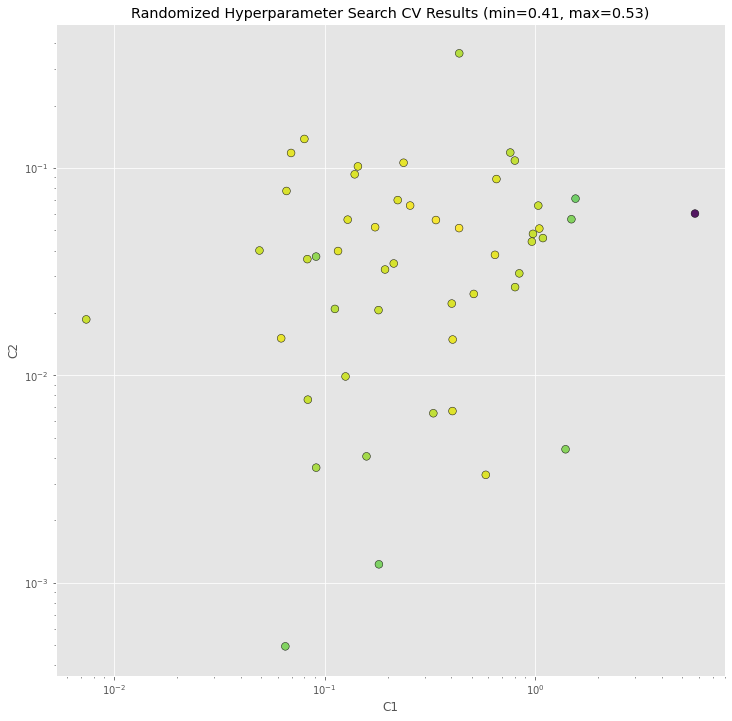

In [69]:
fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".
format(
min(_c), max(_c)
))
ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])
print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [75]:
from collections import Counter
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))
print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])        

Top likely transitions:
[[/word after verb -> [[/word after verb 4.743015
[/word before numeral -> [/word before numeral 4.692834
[/Adjectives -> [/Adjectives 4.672807
Noun phrase -> Noun phrase 4.661057
[/Prepositions -> [/Prepositions 4.335682
Phrasal Verbs -> Phrasal Verbs 3.936567
Numeral word -> Qualitative noun 3.512260
[/[/word before numeral -> [/word before verb 3.456361
Time expression word -> Time expression word 3.286412
[/[/word after verb -> [[/Noun Conjunctions 3.253450
Noun Conjunctions -> Noun Conjunctions 3.235283
[[/Noun Conjunctions -> [/[/word before numeral 3.234202
[[/[/word before numeral -> [/word before numeral 3.217221
[/word before noun -> [[/[/word before numeral 3.138196
abbreviation -> noun    3.125291
[/Pronouns -> [/[/word after verb 3.046636
noun   -> noun    3.042379
word before noun -> word before noun 2.809384
[/noun -> [/Adverbs 2.741440
[[/Phrasal Verbs -> [/[/SS Conjunctions 2.735973

Top unlikely transitions:
Noun phrase -> Numeral word -0.68590

In [80]:
d = []
while True:
    t=input("Text : ")    
    print(get_ner(t))

Text : เมื่อเวลาประมาณ 19.00 น.วันที่ 4 ตุลาคม ผู้สื่อข่าวรายงานว่า ที่บริเวณหน้าบ้านเลขใน อ.เมือง จ.ศรีสะเกษ พ.ต.อ.เทพพิทักษ์ แสงกล้า ผกก.สภ.เมืองศรีสะเกษ พร้อมด้วย พ.ต.ท.สุรพงศ์ วรพิมพ์รัตน์ รอง ผกก.ป. พ.ต.ท.ณฐพงศ์ แก้วเหลา รอง ผกก.(สอบสวน) พ.ต.ท.พิเนตร ดาวเรือง รอง ผกก.สส. เจ้าหน้าที่ตำรวจสายตรวจ เจ้าหน้าที่สายตรวจตำบลทุ่ม เจ้าหน้าที่ ตร.ชุดสืบสวน สภ.เมืองศรีสะเกษ ได้ไปทำการตรวจสอบที่เกิดเหตุกรณีที่เจ้าหน้าที่ชุดสืบสวน สภ.วารินชำราบ ภ.จว.อุบลราชธานี ได้มาล่อซื้อยาบ้าในเขตพื้นที่ สภ.เมืองศรีสะเกษ แต่ปรากฏว่า คนร้ายได้ไหวตัวและได้ใช้อาวุธปืนยิงใส่สายลับที่เข้าไปล่อซื้อยาบ้าจำนวน 3 นัด ทำให้ได้รับบาดเจ็บสาหัส และเจ้าหน้าที่ ตร.ได้รีบนำตัวส่งไปยัง รพ.ศรีสะเกษ เพื่อให้แพทย์ทำการช่วยชีวิตอย่างเร่งด่วนแล้ว พ.ต.อ.เทพพิทักษ์ แสงกล้า ผกก.สภ.เมืองศรีสะเกษ กล่าวว่า จากการตรวจสอบเบื้องต้นทราบว่า เจ้าหน้าที่ชุดสืบสวน สภ.วารินชำราบ ได้จัดให้สายลับเข้าไปทำการล่อซื้อยาบ้าจำนวนประมาณ 2,000 เม็ด ที่บ้านหลังที่เกิดเหตุ โดยมีเจ้าหน้าที่ ตร.ไปคอยดักซุ่มอยู่เพื่อเข้าทำการจับกุม ซึ่งปรากฏว่าหลังจากที่มีการ

KeyboardInterrupt: Interrupted by user

In [81]:
d

[[('เมื่อ', 'SS Conjunctions'),
  ('เวลา', 'noun'),
  ('ประมาณ', 'word before numeral'),
  ('<space>', 'Numeral word'),
  ('19.00', 'Numeral word'),
  ('<space>', 'Numeral word'),
  ('น.', 'abbreviation'),
  ('วันที่', 'noun'),
  ('<space>', 'word before numeral'),
  ('4', 'Numeral word'),
  ('<space>', 'Qualitative noun'),
  ('ตุลาคม', 'noun'),
  ('<space>', 'noun'),
  ('ผู้สื่อข่าว', 'noun'),
  ('รายงาน', 'transitive verb'),
  ('ว่า', 'SS Conjunctions'),
  ('<space>', 'SS Conjunctions'),
  ('ที่', 'Prepositions'),
  ('บริเวณ', 'Noun phrase'),
  ('หน้าบ้าน', 'Noun phrase'),
  ('เลข', 'Noun phrase'),
  ('ใน', 'Prepositions'),
  ('<space>', 'Numeral word'),
  ('อ.', 'abbreviation'),
  ('เมือง', 'noun'),
  ('<space>', 'noun'),
  ('จ.', 'abbreviation'),
  ('ศรีสะเกษ', 'noun'),
  ('<space>', 'noun'),
  ('พ.ต.อ.', 'noun'),
  ('เทพ', 'noun'),
  ('พิทักษ์', 'noun'),
  ('<space>', 'noun'),
  ('แสง', 'noun'),
  ('กล้า', 'noun'),
  ('<space>', 'noun'),
  ('ผกก.', 'noun'),
  ('สภ.', 'abbreviation

In [83]:
with open('model.pkl','wb') as f:
    pickle.dump(crf,f)

In [84]:
with open('model.pkl', 'rb') as f:
    clf2 = pickle.load(f)

In [91]:
text = "วันนี้(วันที่ 5 สิงหาคม 2563) พล.ต.อ.วิสนุ ปราสาททองโอสถ ผู้ช่วย ผบ.ตร.พร้อมด้วย พล.ต.ท.ชินภัทร สารสิน ผบช.ปส.,พล.ต.ต.พรชัย. เจริญวงศ์ รอง ผบช.ปส.พล.ต.ต.วัชระ ทิพย์มงคล ผบก.ปส.3 บช.ปส.พล.ต.ต.บัณฑิต ทิศาภาค ผบก.สกส.บช.ปส. พล.ต.ต.สุรศักดิ์ สุขแสวง ผบก.ภ.จว.ประจวบคีรีขันธ์ นายกิตติพงศ์ สุขภาคกุล ปลัดจังหวัดประจวบคีรีขันธ์ และผู้แทนจากฝ่ายทหารและฝ่ายปกครองที่เกี่ยวข้อง ร่วมกันแถลงผลบูรณาการจับกุม-สกัดกั้นและยึดทรัพย์สินผู้ค้ายาเสพติดรายสำคัญในช่วงสถานการณ์โควิด-19 ยึดของกลางจำนวนมากภายใต้ยุทธการสยบไพรี 63/16 “ทลายขุมทรัพย์จับแก๊งยานรก” ปฏิบัติการ เด็ดปีกภมรวิจิตร โดยในวันนี้ ตำรวจปราบปรามยาเสพติดสนธิกำลังเข้าจับกุม ตรวจค้น ยึดทรัพย์ ในพื้นที่ ทั่วประเทศไทย โดยที่อำเภอหัวหินได้มีการนำหมายศาลเข้าตรวจบ้านหลังหนึ่ง ใน อ.หัวหิน จ.ประจวบคีรีขันธ์เพื่อจับผู้ต้องคดียาเสพติด รายสำคัญ คือ นายสว่าง ภมรวิจิตร อายุ 55 ปี ,นางสาววันเพ็ญ สัตย์ธัญญากุล อายุ 33 ปี ,นายเฉลิมพล ภมรวิจิตร อายุ 34 ปี ,นายบรรลือ ภมรวิจิตร อายุ 28 ปี ,นายเผด็จ แซ่ว่าง อายุ 45 ปี 2 สามีภรรยา หลังสืบทราบว่า นายสว่าง และนางวันเพ็ญ เป็นตัวการสำคัญในการสั่งนำยาเสพติดจากพื้นที่ชายแดนประเทศเพื่อนบ้านทางภาคเหนือ ลงมากระจายสู่ภาคใต้ พร้อมตรวจยึดทรัพย์สินตาม พ.ร.บ.มาตรการ ฯ พ.ศ.2534 ประกอบด้วย บ้านพร้อมที่ดิน จำนวน 24 หลัง ,โฉนดที่ดิน จำนวน 12 ฉบับ ,อาคารพาณิชย์ จำนวน 5 คูหา ,รถยนต์ จำนวน 22 คัน ,รถจักรยานยนต์ จำนวน 27 คัน ,บัญชีเงินฝาก จำนวน 52 บัญชี ,บัตรกดเงินสด จำนวน 5 ใบ  รวมมูลค่าทรัพย์สินที่ตรวจยึดทั้งสิ้นประมาณ 200 ล้านบาท พบความเชื่อมโยงระหว่างกลุ่มผู้ขนยาเสพติดที่ถูกจับก่อนหน้านี้ ในจังหวัดกำแพงเพชร พร้อมยาบ้า กว่า 5 ล้านเม็ด เมื่อวันที่ 3 มีนาคม ที่ผ่านมา และยังพบเส้นทางการโอนเงินและติดต่อทางโทรศัพท์ ระหว่างนางวันเพ็ญ กับกลุ่มผู้ต้องหาอีกด้วย	โดยนายสว่าง สามีที่เป็นชาวไทยภูเขาเผ่าม้ง ที่เคยอาศัยอยู่ในพื้นที่ภาคเหนือ ผันตัวมาทำหน้าที่โบรกเกอร์ สั่งยาเสพติด เเละจัดหาทีมขนลำเลียงได้เพราะรู้เส้นทางเป็นอย่างดี ก่อนที่ 2 ปีนี้ ตัวนายสว่าง จะย้ายถิ่นฐานมาอยู่ที่ จ.ประจวบคีรีขันธ์ เพื่อเปิดร้านขายของทุกอย่าง 20 บาทบังหน้า ชุดสืบสวนเฝ้าติดตามพฤติกรรมนายสว่างเรื่อยมา ก่อนพบว่า ช่วงระยะ 2 ปี ธุรกิจร้านขายของทุกอย่าง 20 บาทของนายสว่างมีเงินหมุนเวียนมากผิดปกติ หนึ่งในจุดผิดสังเกต พบว่าเงินดังกล่าวถูกนำไปสร้างอาคารพาณิชย์ มูลค่ากว่า 45 ล้านบาท ตำรวจจึงรวบรวมหลักฐาน กระทั่งครั้งนี้สามารถออกหมายจับนายสว่างพร้อมภรรยาและลูกชายอีก 2 คนที่มีความเกี่ยวข้องกับการค้ายาเสพติดได้ พล.ต.ท.วิสนุ ปราสาททองโอสถ ผู้ช่วย ผบ.ตร. กล่าวว่า จากการสืบสวนติดตามกลุ่มนักค้ายาเสพติดชาวเขาเผ่าม้ง มีความสัมพันธ์แน่นแฟ้นเกี่ยวดอง ในลักษณะเครือญาติ โดยกลุ่มเครือข่ายนี้มีศักยภาพในการติดต่อสั่งซื้อยาเสพติดจากโรงงานผลิต ในสาธารณรัฐแห่งสหภาพ เมียนมา จัดหา ประสาน สั่งการลำเลียงยาเสพติด นำส่งเครือข่าย ซึ่งเป็นกลุ่มเครือญาติในพื้นที่ตอนใน มีการแบ่งหน้าที่ให้เครือญาติ และลูกหลาน ดำเนินการอย่างชัดเจน ครอบคลุม 3 พื้นที่ 3 ภาค ได้แก่ พื้นที่ต้นทาง ในพื้นที่ภาคเหนือซึ่งใกล้แหล่งผลิตและพื้นที่นำเข้า สะดวก ในการจัดหาเครือข่ายผู้ลำเลียงชาวเขาในพื้นที่เดียวกัน พื้นที่กลางทาง ในพื้นที่ กรุงเทพมหานคร ซึ่งเป็นจุดยุทธศาสตร์ใหม่ที่ใช้เป็นบ้านพัก สะดวกในการติดต่อเดินทางระหว่าง 2 พื้นที่ และอยู่ไม่ห่างจากจุดรับมอบยาเสพติดระหว่างกลุ่มผู้ลำเลียงทั้ง 2 ระยะ เพื่อส่งต่อไปยังพื้นที่ภาคใต้ต่อไป พื้นที่ปลายทาง ใช้เป็นแหล่งฟอกเงินและเป็นจุดกระแสเงินต้นทางในการโอนเงินค่ายาเสพติดและ ค่าจ้างลำเลียง โดยใช้ธุรกิจค้าเสื้อผ้า และร้านจำหน่ายสินค้าที่ระลึกชาวเขา บังหน้า โดยไม่ได้ต้องการหวังผลกำไรเป็นหลัก กลุ่มเครือข่ายนี้ใช้กระบวนการฟอกเงินโดยให้เครือญาติ ลูกหลาน เปิดบัญชีธนาคารและทำธุรกรรมทางการเงิน รวมทั้งแปรสภาพเงินดังกล่าวไปเป็นอสังหาริมทรัพย์และโอนกรรมสิทธิ์ให้เป็น ผู้ถือครองทั้งที่บุคคลเหล่านั้นมีการประกอบสัมมาชีพ ที่ไม่สอดคล้องกับรายได้และทรัพย์สิน ทั้งนี้ก็เพื่อป้องกันการตรวจสอบ และทำให้เกิดความซับซ้อนในการตรวจสอบจากเจ้าหน้าที่รัฐ สำหรับปฏิบัติการวันนี้ ตำรวจกระจายกำลังลงพื้นที่ 4 จังหวัด 30 เป้าหมาย คือจังหวัด เชียงใหม่ 22 เป้าหมาย, เชียงราย 1 เป้าหมาย, กรุงเทพ 1 เป้าหมาย และประจวบคีรีขันธ์ อีก 6 เป้าหมาย พบอีกว่าเครือข่าย ของนายสว่างมีทรัพย์สินจำนวนมาก โดยทรัพย์สินทั้งหมด มีการแบ่งชื่อผู้ครอบครอง เป็นเครือญาติ ของนายสว่างทั้งหมด"
#_tokenizer = Tokenizer(custom_dict=trie, engine='newmm')
word_cut=_tokenizer.word_tokenize(text)
list_word=pos_tag(word_cut,engine='perceptron')
X_test = extract_features([(data,list_word[i][1]) for i,data in enumerate(word_cut)])

In [92]:
clf2.predict_single(X_test)

['Time expression word',
 'Time expression word',
 'Time expression word',
 'word before numeral',
 'Numeral word',
 'Qualitative noun',
 'noun',
 'word before numeral',
 'Numeral word',
 'Numeral word',
 '[/noun',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'Noun phrase',
 'noun',
 'noun',
 'noun',
 'noun',
 'noun',
 'noun',
 'noun',
 'noun',
 'Numeral word',
 'Numeral word',
 'Qualitative noun',
 'transitive verb',
 'Noun phrase',
 'Noun phrase'